# Case Study 1: Finding the winning strategy in a card game

## Problem statement
Would you like to win a bit of money? Let’s wager on a card game for minor stakes. In front of you is a shuffled deck of cards. All 52 cards lie face down. Half the cards are red, and half are black. I will proceed to flip over the cards one by one. If the last card I flip over is red, you’ll win a dollar. Otherwise, you’ll lose a dollar.

Here’s the twist: you can ask me to halt the game at any time. Once you say “Halt,” I will flip over the next card and end the game. That next card will serve as the final card. You will win a dollar if it’s red, as shown in figure CS1.1.

We can play the game as many times as you like. The deck will be reshuffled every time. After each round, we’ll exchange money. What is your best approach to winning this game?

### Overview
To address the problem at hand, we will need to know how to
1. Compute the probabilities of observable events using sample space analysis.
2. Plot the probabilities of events across a range of interval values.
3. Simulate random processes, such as coin flips and card shuffling, using Python.
4. Evaluate our confidence in decisions drawn from simulations using confidence interval analysis.

**This section covers**
- Card game simulations
- Probabilistic strategy optimization
- Confidence intervals

## Solution

Our aim is to play a card game in which the cards are iteratively flipped until we tell the dealer to stop. Then one additional card is flipped. If that card is red, we win a dollar; otherwise, we lose a dollar. Our goal is to discover a strategy that best pre- dicts a red card in the deck. We will do so by
1. Developing multiple strategies for predicting red cards in a randomly shuffled deck.
2. Applying each strategy across multiple simulations to compute its probability of success within a high confidence interval. If these computations prove to be intractable, we will instead focus on those strategies that perform best across a 10-card sample space.
3. Returning the simplest strategy associated with the highest probability of success.

## 4.1 Predicting red cards in a shuffled deck
We start by creating a deck holding 26 red cards and 26 black cards. Black cards are represented by 0s, and red cards are represented by 1s.

In [30]:
# Modelling a 52-card deck
red_cards = 26 * [1]
black_cards = 26 * [0]
unshuffled_deck = red_cards + black_cards

# Shuffling a 52-card deck
import numpy as np
import matplotlib.pyplot as plt
import itertools

np.random.seed(1)
shuffled_deck = np.random.permutation(unshuffled_deck)

Now we iteratively flip over the cards in the deck, stopping when the next card is more likely to be red. Then we flip over the next card. We win if that card is red.

How do we decide when we should stop? One simple strategy is to terminate the game when the number of red cards remaining in the deck is greater than the number of black cards remaining in the deck. Let’s execute that strategy on the shuffled deck.

In [17]:
# Coding a card game strategy
remaining_red_cards = 26
for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card
    # Subtracts the total cards seen thus far from 52. This total equals i+1, since i is initially set to zero.
    # Alternatively, we can run enumerate(shuffled_dec[:-1],1) so that i is initially set to 1.
    remaining_total_cards = 52 - i - 1
    if remaining_red_cards / remaining_total_cards > 0.5:
        break
        
print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i + 1]
color = 'red' if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f"We have {'won' if final_card else 'lost'}!")

Stopping the game at index 0.
The next card in the deck is red.
We have won!


The strategy yielded a win on our very first try. Our strategy halts when the fraction of remaining red cards is greater than half of the remaining total cards. We can generalize that fraction to equal a `min_red_fraction` parameter, thus halting when the red card ratio is greater than the inputted parameter value. This generalized strategy is implemented next with `min_red_fraction` preset to 0.5.

In [21]:
# Generalizing the card game strategy
np.random.seed(0)
total_cards = 52
total_red_cards = 26
def execute_strategy(min_fraction_red=0.5, shuffled_deck=None, return_index=False):
    if shuffled_deck is None:
        # Shuffles the unshuffled deck if no input deck is provided
        shuffled_deck = np.random.permutation(unshuffled_deck)
        
    remaining_red_cards = total_red_cards
    
    for i, card in enumerate(shuffled_deck[:-1]):
        remaining_red_cards -= card
        fraction_red_cards = remaining_red_cards / (total_cards - i - 1)
        if fraction_red_cards > min_fraction_red:
            break
    
    # Optionally returns the card index along with the final card
    return (i+1, shuffled_deck[i+1]) if return_index else shuffled_deck[i+1]

### 4.1.1 Estimating the probability of strategy success

Let’s apply our basic strategy to a series of 1,000 random shuffles.

In [22]:
# Running the strategy over 1000 shuffles
observations = np.array([execute_strategy() for _ in range(1000)])

The total fraction of 1s in observations corresponds to the observed fraction of red cards and therefore to the fraction of wins. We can compute this fraction by summing the 1s in `observations` and dividing by the array size. As an aside, that computation can also be carried out by calling `observations.mean()`.

In [23]:
# Computing the frequency of wins
frequency_wins = observations.sum() / 1000
assert frequency_wins == observations.mean()
print(f"The frequency of wins is {frequency_wins}")

The frequency of wins is 0.511


We’ve won 51.1% of the total games! Our strategy appears to be working: 511 wins and 489 losses will net us a total profit of $22.

In [24]:
# Computing total profit
dollars_won = frequency_wins * 1000
dollars_lost = (1 - frequency_wins) * 1000
total_profit = dollars_won - dollars_lost
print(f"Total profit is ${total_profit:.2f}")

Total profit is $22.00


The strategy worked well for a sample size of 1,000 shuffles. We now plot the strategy’s win-frequency convergence over a series of sample sizes ranging from 1 through 10,000.

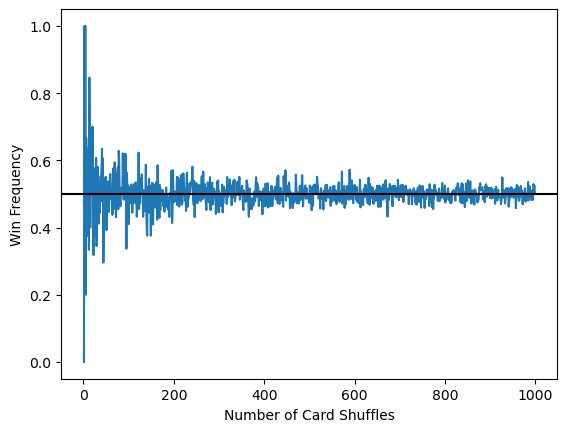

The win-frequency for 10,000 shuffles is 0.5035035035035035


In [28]:
# Plotting simulated frequencies of wins
np.random.seed(0)
def repeat_game(number_repeats):
    observations = np.array([execute_strategy()
                            for _ in range(number_repeats)])
    return observations.mean()

frequencies = []
for i in range(1, 1000):
    frequencies.append(repeat_game(i))
    
plt.plot(list(range(1, 1000)), frequencies)
plt.axhline(0.5, color='k')
plt.xlabel('Number of Card Shuffles')
plt.ylabel('Win Frequency')
plt.show()
print(f"The win-frequency for 10,000 shuffles is {frequencies[-1]}")

The strategy yields a win frequency of over 50% when 10,000 card shuffles are sampled. However, the strategy also fluctuates above and below 50% throughout the entire sampling process. How confident are we that the probability of a win is actually greater than 0.5? We can find out using confidence interval analysis. We compute the confidence interval by sampling 10,000 card shuffles 300 times, for a total of 3 million shuffles. Shuffling an array is a computationally expensive procedure, so the following code takes approximately 40 seconds to run.

The frequency range 0.488938 - 0.509494 represents a 97.00% confidence interval


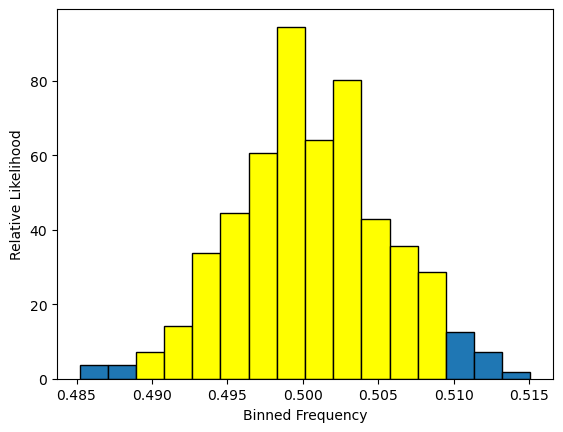

In [29]:
# Computing a high confidence interval
def compute_high_confidence_interval(likelihoods, bin_width):
    peak_index = likelihoods.argmax()
    area = likelihoods[peak_index] * bin_width
    start_index, end_index = peak_index, peak_index + 1
    while area < 0.95:
        if start_index > 0:
            start_index -= 1
        if end_index < likelihoods.size - 1:
            end_index += 1
        
        area = likelihoods[start_index: end_index + 1].sum() * bin_width 
    
    range_start, range_end = bin_edges[start_index], bin_edges[end_index]
    range_string =  f"{range_start:.6f} - {range_end:.6f}"
    print((f"The frequency range {range_string} represents a "
          f"{100 * area:.2f}% confidence interval"))
    return start_index, end_index

# Computing the confidence interval for 3 million shuffles
np.random.seed(0)
frequency_array = np.array([repeat_game(10000) for _ in range(300)])

likelihoods, bin_edges, patches = plt.hist(frequency_array, bins='auto',
                                          edgecolor='black', density=True)
bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

for i in range(start_index, end_index):
    patches[i].set_facecolor('yellow')
plt.xlabel('Binned Frequency')
plt.ylabel('Relative Likelihood')

plt.show()

We are quite confident that the actual probability lies somewhere between 0.488 and 0.509. However, we still don’t know whether that probability is above 0.5 or below 0.5. This is a problem: even a minor misinterpretation of the true probability could cause us to lose money.

Imagine that the true probability is 0.5001. If we apply our strategy to 1 billion shuffles, we should expect to win $200,000.

Now suppose we were wrong, and the actual probability is 0.4999. In this scenario, we will lose $200,000. A tiny error over the fourth decimal space could cost us hundreds of thousands of dollars.

We must be absolutely certain that the true probability lies above 0.5. Thus, we must narrow the 95% confidence interval by increasing the sample size at the expense of running time. The following code samples 50,000 shuffles over 3,000 iterations. It takes approximately an hour to run.

Perhaps we can gain more insight by applying our strategies to a 10-card deck. That deck’s sample space can be explored in its entirety, thus letting us compute the exact probability of a win.

## 4.2 Optimizing strategies using the sample space for a 10-card deck

The following code computes the sample space for a 10-card deck. Then it applies our basic strategy to that sample space. The final output is the probability that the strategy will yield a win.

In [32]:
# Defining an event-detection function
def get_matching_event(event_condition, sample_space):
    return set([outcome for outcome in sample_space
               if event_condition(outcome)])

# Defining a generalized event probability function
def compute_event_probability(event_condition, generic_sample_space):
    event = get_matching_event(event_condition, generic_sample_space)
    if type(generic_sample_space)  == type(set()): # check whether generic_event_space is a set
        return len(event) / len(generic_sample_space)
    
    event_size = sum(generic_sample_space[outcome] 
                     for outcome in event)
    return event_size / sum(generic_sample_space.values())

# Applying a basic strategy to a 10-card deck
total_cards = 10
total_red_cards = int(total_cards / 2)
total_black_cards = total_red_cards
unshuffled_deck = [1] * total_red_cards + [0] * total_black_cards
sample_space = set(itertools.permutations(unshuffled_deck))
# Event condition where our basic strategy yields a win
win_condition = lambda x: execute_strategy(shuffled_deck=np.array(x))
prob_win = compute_event_probability(win_condition, sample_space)
print(f"Probability of a win is {prob_win}")

Probability of a win is 0.5


Surprisingly, our basic strategy yields a win only 50% of the time. This is no better than selecting the first card at random! Maybe our `min_red_fraction` parameter was insufficiently low. We can find out by sampling all the two-decimal `min_red_fraction` values between 0.50 and 1.0. The following code computes the win probabilities over a range of `min_red_fraction` values and returns the minimum and maximum probabilities.

In [35]:
# Applying multiple strategies to a 10-card deck
def scan_strategies():
    fractions = [value / 100 for value in range(50, 100)]
    probabilities = []
    for frac in fractions:
        win_condition = lambda x: execute_strategy(frac, shuffled_deck=np.array(x))
        probabilities.append(compute_event_probability(win_condition, sample_space))
    
    return probabilities

probabilities = scan_strategies()
print(f"Lowest probability of win is {min(probabilities)}")
print(f"Highest probability of win is {max(probabilities)}")

Lowest probability of win is 0.5
Highest probability of win is 0.5


Both the lowest and highest probabilities are equal to 0.5! None of our strategies have outperformed a random card choice. Perhaps adjusting the deck size will yield some improvement. Let’s analyze the sample spaces of decks containing two, four, six, and eight cards. We apply all strategies to each sample space and return their probabilities of winning. Then we search for a probability that isn’t equal to 0.5.

In [36]:
# Applying multiple strategies to multiple decks
for total_cards in [2, 4, 6, 8]:
    total_red_cards = int(total_cards / 2)
    total_black_cards = total_red_cards
    unshuffled_deck = [1] * total_red_cards + [0] * total_black_cards
    
    sample_space = set(itertools.permutations(unshuffled_deck))
    probabilities = scan_strategies()
    if all(prob == 0.5 for prob in probabilities):
        print(f"No winning strategy found for deck of size {total_cards}")
    else:
        print(f"Winning strategy found for deck of size {total_cards}")

No winning strategy found for deck of size 2
No winning strategy found for deck of size 4
No winning strategy found for deck of size 6
No winning strategy found for deck of size 8


All of the strategies yield a probability of 0.5 across the small decks. Each time we increase the deck size, we add two additional cards to the deck, but this fails to improve performance. A strategy that fails on a 2-card deck continues to fail on a 4- card deck, and a strategy that fails on an 8-card deck continues to fail on a 10-card deck. We can extrapolate this logic even further. A strategy that fails on a 10-card deck will probably fail on a 12-card deck, and thus on a 14-card deck and a 16-card deck. Eventually, it will fail on a 52-card deck. Qualitatively, this inductive argument makes sense. Mathematically, it can be proven to be true. Right now, we don’t need to concern ourselves with the math. What’s important is that our instincts have been proven wrong. Our strategies don’t work on a 10-card deck, and we have little reason to believe they will work on a 52-card deck. Why do the strategies fail?

Intuitively, our initial strategy made sense: if there are more red cards than black cards in the deck, then we are more likely to pick a red card from the deck. However, we failed to take into account those scenarios when the red cards never outnumber the black cards. For instance, suppose the first 26 cards are red and the remainder are black. In these circumstances, our strategies will fail to halt, and we will lose. Also, let’s consider a shuffled deck where the first 25 cards are red, the next 26 cards are black, and the final card is red. Here, our strategy will fail to halt, but we will still win. It seems each strategy can lead to one of four scenarios:
- Strategy halts and the next card is red. We win.
- Strategy halts and the next card is black. We lose.
- Strategy doesn’t halt and the final card is red. We win.
- Strategy doesn’t halt and the final card is black. We lose.

Let’s sample how frequently the four scenarios occur across 50,000 card shuffles. We record these frequencies over our range of two-digit `min_red_fraction` values. We then plot each `min_red_fraction` value against the occurrence rates observed from the four scenarios .

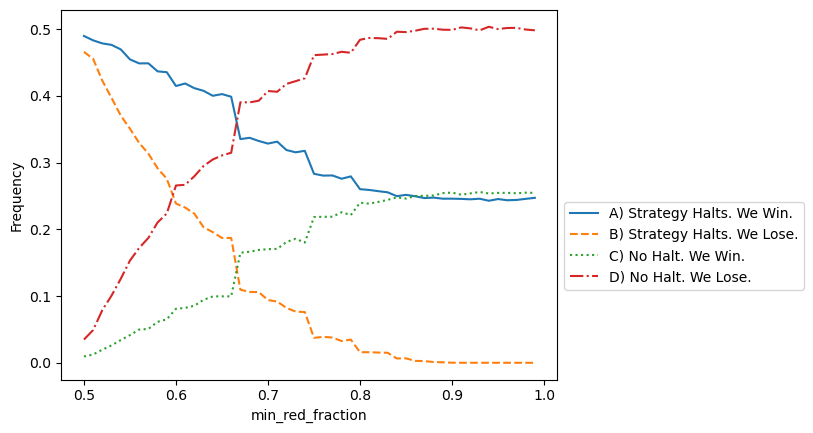

In [39]:
# Plotting strategy outcomes across a 52-card deck
np.random.seed(0)
total_cards = 52
total_red_cards = 26
unshuffled_deck = red_cards + black_cards

def repeat_game_detailed(number_repeats, min_red_fraction):
    
    # We execute a strategy across num_repeats simulations
    observations = [execute_strategy(min_red_fraction, return_index=True)
                                    for _ in range(num_repeats)]
    # This list contains all instances of wins
    successes = [index for index, card, in observations if card == 1]
    # Scenario where our strategy halts and we win
    halt_success = len([index for index in successes if index != 51])
    # Scenario where our strategy doesn't halt and we win
    no_halt_success = len(successes) - halt_success
    
    # This list contains all instances of losses
    failures = [index for index, card, in observations if card == 0]
    # Scenario where our strategy halts and we lose
    halt_failure = len([index for index in failures if index != 51])
    # Scenario where our strategy doesn't halt and we lose
    no_halt_failure = len(failures) - halt_failure
    result = [halt_success, halt_failure, no_halt_success, no_halt_failure]
    # We return the observed frequencies for all four scenarios
    return [r / number_repeats for r in result]

fractions = [value / 100 for value in range(50, 100)]
num_repeats = 50000
result_types = [[], [], [], [], []]

# We scan the scenario frequencies across multiple strategies
for fraction in fractions:
    result = repeat_game_detailed(num_repeats, fraction)
    for i in range(4):
        result_types[i].append(result[i])
        
plt.plot(fractions, result_types[0],
        label='A) Strategy Halts. We Win.')
plt.plot(fractions, result_types[1], linestyle='--',
        label='B) Strategy Halts. We Lose.')
plt.plot(fractions, result_types[2], linestyle=':',
        label='C) No Halt. We Win.')
plt.plot(fractions, result_types[3], linestyle='-.',
        label='D) No Halt. We Lose.')
plt.xlabel('min_red_fraction')
plt.ylabel('Frequency')
# The bbox_to_anchor parameter is used to position the legend above the plot to avoid overlap with the four plotted curves
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

In [42]:
# The optimal winning strategy
def otpimal_strategy(shuffled_deck):
    return shuffled_deck[0]
